# Analysis of homogenized temperature data from the Netherlands

This notebook contains some Python code to analyze [homogenized monthly temperature data since 1901](http://projects.knmi.nl/klimatologie/onderzoeksgegevens/homogeen_260/tg_hom_mnd260.txt) from KNMI's *De Bilt* weather station.

## Import prerequisites:

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from scipy.optimize import curve_fit

from bokeh.io       import show, output_notebook
from bokeh.layouts  import layout
from bokeh.models   import Range1d
from bokeh.palettes import d3
from bokeh.plotting import figure

output_notebook()

tools = "pan,wheel_zoom,box_zoom,reset,save".split(',')

pd.set_option('display.max_columns', 40)

mycolors = [d3['Category10'][10][i] for i in range(10)]

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,scipy,matplotlib,bokeh
print("")
%watermark -m

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading BokehJS ...

Author: gmalim

last updated: Wed Aug 08 2018

CPython 3.6.5
IPython 6.5.0

numpy 1.15.0
pandas 0.23.4
scipy 1.1.0
matplotlib 2.2.2
bokeh 0.13.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


In [2]:
df = pd.read_csv('tg_hom_mnd260.txt', names=['DATE', 'TGH'], skiprows=28, sep=' ', skipinitialspace=True)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df = df.set_index('DATE')

print(df.shape)

(1411, 1)


In [3]:
# Date selection:

start_year = 1901
end_year   = 2017

start_date = '{}-01-01'.format(start_year)
end_date   = '{}-12-31'.format(end_year)

df = df.loc[start_date:end_date]

print(df.shape)

(1404, 1)


In [4]:
display(df.describe().round(1))

#npoints = df.shape[0]

,TGH
count,1404.0
mean,9.4
std,5.6
min,-6.8
25%,4.7
50%,9.3
75%,14.5
max,22.2


In [5]:
print("--> Total number of months in data set with homogenized monthly temperatures > 20 C =", len(df[(df['TGH']>20)]))

--> Total number of months in data set with homogenized monthly temperatures > 20 C = 5


In [6]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI homogenized monthly temperature data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,30)

fig1.circle(x=df.index, y=df.TGH, size=5, color=mycolors[2], muted_color=mycolors[2], alpha=0.5, muted_alpha=0.03)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [7]:
def mygaussian(x, ampl, mu, sigma):
    #return ampl/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
    return ampl*np.exp(-(x-mu)**2/(2*sigma**2))

pg_min = (  0,  -10,  0.1)
pg_max = (100,   30, 20.0)
pg_bounds = (pg_min, pg_max)

In [8]:
df = df.reset_index()

df['month'] = df['DATE'].dt.strftime('%m')
df['month'] = df['month'].astype('int64')

df_jan = df[(df['month'] == 1) | (df['month'] == 2)]
df_jul = df[(df['month'] == 7) | (df['month'] == 8)]

Fitted gaussian (January): 20.5*exp(-(x- 3.0)^2/(2*2.2^2))
Fitted gaussian    (July): 33.7*exp(-(x-16.6)^2/(2*1.4^2))


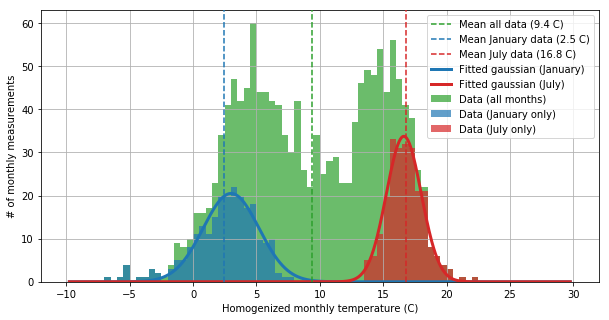

In [9]:
plt.figure(figsize=(10,5))

bincontents,     binedges,     _ = plt.hist(x=df.TGH,     range=(-10,30), bins=80, alpha=0.7, color=mycolors[2], 
                                            label='Data (all months)')
bincontents_jan, binedges_jan, _ = plt.hist(x=df_jan.TGH, range=(-10,30), bins=80, alpha=0.7, color=mycolors[0], 
                                            label='Data (January only)')
bincontents_jul, binedges_jul, _ = plt.hist(x=df_jul.TGH, range=(-10,30), bins=80, alpha=0.7, color=mycolors[3], 
                                            label='Data (July only)')

bincentralvalues_jan = [(binedges_jan[i]+binedges_jan[i+1])/2 for i in range(len(binedges_jan)-1)]
bincentralvalues_jul = [(binedges_jul[i]+binedges_jul[i+1])/2 for i in range(len(binedges_jul)-1)]

TGH_mean     = df.TGH.mean()
TGH_mean_jan = df_jan.TGH.mean()
TGH_mean_jul = df_jul.TGH.mean()

label_all = 'Mean all data ({:.1f} C)'    .format(TGH_mean)
label_jan = 'Mean January data ({:.1f} C)'.format(TGH_mean_jan)
label_jul = 'Mean July data ({:.1f} C)'   .format(TGH_mean_jul)

plt.axvline(x=TGH_mean,     linestyle='--', color=mycolors[2], zorder=20, label=label_all)
plt.axvline(x=TGH_mean_jan, linestyle='--', color=mycolors[0], zorder=20, label=label_jan)
plt.axvline(x=TGH_mean_jul, linestyle='--', color=mycolors[3], zorder=20, label=label_jul)

# ---

x_data_jan = bincentralvalues_jan
y_data_jan = bincontents_jan

pg_start = [20, TGH_mean_jan, 2]

pg_jan_opt, pg_jan_cov = curve_fit(mygaussian, x_data_jan, y_data_jan, p0=pg_start, bounds=pg_bounds)

#label_g_jan = "Fitted gaussian: {:.1f}/(sigma*sqrt(2π))*exp(-(x-{:.1f})^2/(2*{:.1f}^2))"\
label_g_jan = "Fitted gaussian (January): {:.1f}*exp(-(x-{:4.1f})^2/(2*{:.1f}^2))"\
              .format(pg_jan_opt[0], pg_jan_opt[1], pg_jan_opt[2])

print(label_g_jan)

# ---

x_data_jul = bincentralvalues_jul
y_data_jul = bincontents_jul

pg_start = [20, TGH_mean_jul, 2]

pg_jul_opt, pg_jul_cov = curve_fit(mygaussian, x_data_jul, y_data_jul, p0=pg_start, bounds=pg_bounds)

#label_g_jul = "Fitted gaussian: {:.1f}/(sigma*sqrt(2π))*exp(-(x-{:.1f})^2/(2*{:.1f}^2))"\
label_g_jul = "Fitted gaussian    (July): {:.1f}*exp(-(x-{:4.1f})^2/(2*{:.1f}^2))"\
              .format(pg_jul_opt[0], pg_jul_opt[1], pg_jul_opt[2])

print(label_g_jul)

# ---

x_fit_jan = np.linspace(min(x_data_jan), max(x_data_jan), num=len(x_data_jan)*10)
x_fit_jul = np.linspace(min(x_data_jul), max(x_data_jul), num=len(x_data_jul)*10)

y_fit_jan = mygaussian(x_fit_jan, pg_jan_opt[0], pg_jan_opt[1], pg_jan_opt[2])
y_fit_jul = mygaussian(x_fit_jul, pg_jul_opt[0], pg_jul_opt[1], pg_jul_opt[2])

plt.plot(x_fit_jan, y_fit_jan, label="Fitted gaussian (January)",
          lw=3, color=mycolors[0], alpha=1)

plt.plot(x_fit_jul, y_fit_jul, label="Fitted gaussian (July)",
          lw=3, color=mycolors[3], alpha=1)

# ---

plt.legend(loc='best')
plt.ylabel('# of monthly measurements')
plt.xlabel('Homogenized monthly temperature (C)')
plt.grid(True)

In [10]:
x_data     = df.index
y_data     = df.TGH
x_data_jan = df_jan.index
y_data_jan = df_jan.TGH
x_data_jul = df_jul.index
y_data_jul = df_jul.TGH

In [11]:
def myfunc1(x, ampl, hoffset, voffset): # sine function
    return ampl*np.sin(2*np.pi/12*(x - hoffset)) + voffset

p1_start = [1, 0, 0]
p1_min = (     0,  0, -np.inf)
p1_max = (np.inf, 12,  np.inf)
p1_bounds = (p1_min, p1_max)

In [12]:
def myfunc2(x, slope, voffset): # 1st order polynomial function
    return slope*x + voffset

p2_start = [0, 0]
p2_min = (-np.inf, -np.inf)
p2_max = ( np.inf,  np.inf)
p2_bounds = (p2_min, p2_max)

In [13]:
def myfunc3(x, ampl, hoffset, voffset, slope): # sine + 1st order polynomial function
    return ampl*np.sin(2*np.pi/12*(x - hoffset)) + voffset + slope*x

p3_start = [1, 0, 0, 0]
p3_min = (     0,  0, -np.inf, -np.inf)
p3_max = (np.inf, 12,  np.inf,  np.inf)
p3_bounds = (p3_min, p3_max)

In [14]:
p1_opt, p1_cov = curve_fit(myfunc1, x_data, y_data, p0=p1_start, bounds=p1_bounds)

label1 = "Fitted sine: {:.1f}*sin(2π(t - {:.1f})/12) + {:.1f}"\
         .format(p1_opt[0], p1_opt[1], p1_opt[2])

print(label1)

Fitted sine: 7.5*sin(2π(t - 3.2)/12) + 9.4


In [15]:
p2_opt, p2_cov = curve_fit(myfunc2, x_data, y_data, p0=p2_start, bounds=p2_bounds)

label2 = "Fitted pol1: {:.2}*t + {:.1f}"\
         .format(p2_opt[0], p2_opt[1])

print(label2)

Fitted pol1: 0.0012*t + 8.6


In [16]:
p3_opt, p3_cov = curve_fit(myfunc3, x_data, y_data, p0=p3_start, bounds=p3_bounds)

label3 = "Fitted sine + pol1: {:.1f}*sin(2π(t - {:.1f})/12) + {:.1f} + {:.2}*t"\
         .format(p3_opt[0], p3_opt[1], p3_opt[2], p3_opt[3])

print(label3)

Fitted sine + pol1: 7.5*sin(2π(t - 3.2)/12) + 8.6 + 0.0012*t


In [17]:
x_fit = np.linspace(x_data.min(), x_data.max(), num=len(x_data)*10)

y_fit1 = myfunc1(x_fit, p1_opt[0], p1_opt[1], p1_opt[2])
y_fit2 = myfunc2(x_fit, p2_opt[0], p2_opt[1],)
y_fit3 = myfunc3(x_fit, p3_opt[0], p3_opt[1], p3_opt[2], p3_opt[3])

In [18]:
fig1 = figure(plot_width=900, plot_height=450, tools=tools, toolbar_location='above')
fig1.title.text = "Homogenized monthly temperatures {}-{}, KNMI weather station De Bilt".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Time (months since Jan 1901)"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,30)

fig1.circle(x=df.index, y=df.TGH, legend='Data',
            size=5, color=mycolors[2], muted_color=mycolors[2], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit1, legend=label1,
          line_width=3, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit2, legend=label2,
          line_width=3, color=mycolors[1], muted_color=mycolors[1], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit3, legend=label3,
          line_width=3, color=mycolors[3], muted_color=mycolors[3], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [19]:
p_jan, p_jan_cov = curve_fit(myfunc2, x_data_jan, y_data_jan, p0=p2_start, bounds=p2_bounds)

label_jan = "Fitted pol1: {:.2}*t + {:.1f}".format(p_jan[0], p_jan[1])

print(label_jan)

Fitted pol1: 0.001*t + 1.8


In [20]:
p_jul, p_jul_cov = curve_fit(myfunc2, x_data_jul, y_data_jul, p0=p2_start, bounds=p2_bounds)

label_jul = "Fitted pol1: {:.2}*t + {:.1f}".format(p_jul[0], p_jul[1])

print(label_jul)

Fitted pol1: 0.0015*t + 15.7


In [21]:
y_fit_jan = myfunc2(x_fit, p_jan[0], p_jan[1])
y_fit_jul = myfunc2(x_fit, p_jul[0], p_jul[1])

In [22]:
fig1 = figure(plot_width=900, plot_height=450, tools=tools, toolbar_location='above')
fig1.title.text = "Homogenized monthly temperatures {}-{}, KNMI weather station De Bilt".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Time (months since January 1901)"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,30)

fig1.circle(x=df.index, y=df.TGH, legend='All data',
            size=5, color=mycolors[2], muted_color=mycolors[2], alpha=0.7, muted_alpha=0.03)

fig1.circle(x=df_jul.index, y=df_jul.TGH, legend='July data',
            size=10, color=mycolors[3], muted_color=mycolors[3], alpha=0.7, muted_alpha=0.03)

fig1.circle(x=df_jan.index, y=df_jan.TGH, legend='January data',
            size=10, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit2, legend=label2,
          line_width=3, color=mycolors[2], muted_color=mycolors[2], alpha=1, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit_jul, legend=label_jul,
          line_width=3, color=mycolors[3], muted_color=mycolors[3], alpha=1, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit_jan, legend=label_jan,
          line_width=3, color=mycolors[0], muted_color=mycolors[0], alpha=1, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [23]:
print(p2_cov)

[[ 1.34826231e-07 -9.45806019e-05]
 [-9.45806019e-05  8.84959171e-02]]


In [24]:
p2_err = np.sqrt(np.diag(p2_cov))

print(p2_err)

[0.00036719 0.29748263]


In [25]:
def f(t,N0,tau):
    """The model function"""
    return N0*np.exp(-t/tau)

[987.6628536  102.24436281]
[[129.72610791 -13.42026898]
 [-13.42026898   3.0705145 ]]
chisq = 43.325215705835795 df = 49


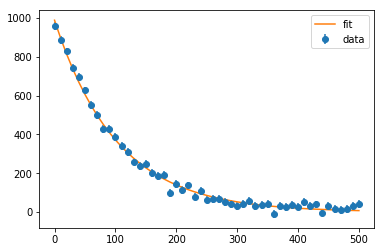

In [27]:
# Model parameters
T = 500
dt = 10
N0 = 1000
tau = 100
stdev = 20

# Create the artificial dataset
nobs = int(T/dt + 1.5)
t = dt*np.arange(nobs)
N = f(t,N0,tau)
Nfluct = stdev*np.random.normal(size=nobs)
N = N + Nfluct
sig = np.zeros(nobs) + stdev

# Fit the curve
start = (1100, 90)
popt, pcov = curve_fit(f,t,N,sigma = sig,p0 = start,absolute_sigma=True)
print(popt)
print(pcov)

# Compute chi square
Nexp = f(t, *popt)
r = N - Nexp
chisq = np.sum((r/stdev)**2)
df = nobs - 2
print('chisq =',chisq,'df =',df)

# Plot the data with error bars along with the fit result
plt.errorbar(t, N, yerr=sig, fmt = 'o', label='data')
plt.plot(t, Nexp, label='fit')
plt.legend()
plt.show()
